- cancel modifying timestamp
- add unique content_id cumnum

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation
from bitarray import bitarray
from lightgbm import LGBMClassifier

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc="progress: ")

_ = np.seterr(divide='ignore', invalid='ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def make_bitarray():
    a = bitarray(32737, endian='little')
    a.setall(True)   
    return a

In [4]:
FULL_TRAIN = False

# Preprocess

In [5]:
data_types_dict = {
    #'row_id': 'uint32',
    'timestamp': 'uint64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [6]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

#lectures = pd.read_csv("../input/riiid-test-answer-prediction/lectures.csv")
#train_lec = train_df[train_df["answered_correctly"] == -1].copy().reset_index(drop=True)
#train_lec = train_lec.astype(data_types_dict)
#train_lec = train_lec.merge(lectures[["lecture_id", "tag"]], left_on="content_id", right_on="lecture_id", how="left")
#train_lec.drop(["lecture_id"], axis=1, inplace=True)
#train_lec["tag"] = train_lec["tag"].astype(str)
#train_lec["tag"] = train_lec.groupby("user_id")["tag"].apply(lambda x: (x+' ').cumsum())

train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df['timestamp'] = (train_df['timestamp'] // 86400000) + 1 # days from start
train_df = train_df.astype(data_types_dict)

#user_learning_time = train_df.drop_duplicates(["user_id","timestamp"])[["timestamp", "user_id"]].copy().reset_index(drop=True)
#user_learning_time["blank"] = user_learning_time.groupby("user_id")["timestamp"].diff()
#user_learning_time["blank"] -= 1
#user_learning_time["blank"] = user_learning_time["blank"].fillna(0)
#user_learning_time["cont_days"] = user_learning_time.groupby("user_id")["timestamp"].diff().ne(1).cumsum()
#user_learning_time["cont_days"] = user_learning_time.groupby(["user_id", 'cont_days']).cumcount()+1

if FULL_TRAIN:
    train_size = 40
else:
    train_size = 24
    valid_size = 6
train_index = list(train_df.groupby('user_id').tail(train_size).index)

In [7]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3], #, 4
    dtype={'question_id': 'int16', 'part': 'int8'}  #, 'tags': 'object'
)
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
train_df.drop(columns=['question_id'], inplace=True)

In [8]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
user_correctness_array = np.array(cum['cumsum'] / cum['cumcount'])
user_correctness_array = user_correctness_array[train_index]
train_df.drop(columns=['lag'], inplace=True)
del cum

In [9]:
train_df["reading_part"] = train_df["part"] >=5
train_df["reading_part"] = train_df["reading_part"].astype("int8")
train_df['reading_part_lag'] = train_df.groupby('user_id')["reading_part"].shift()
cum = train_df.groupby('user_id')['reading_part_lag'].agg(['cumsum']) 
reading_part_count_array = cum['cumsum'].values
reading_part_count_array = reading_part_count_array[train_index] 
train_df.drop(columns=['reading_part_lag', 'reading_part'], inplace=True)
del cum

In [10]:
train_df["listening_part"] = (train_df["part"] >=1) | (train_df["part"] <=4)
train_df["listening_part"] = train_df["listening_part"].astype("int8")
train_df['listening_part_lag'] = train_df.groupby('user_id')["listening_part"].shift()
cum = train_df.groupby('user_id')['listening_part_lag'].agg(['cumsum']) 
listening_part_count_array = cum['cumsum'].values
listening_part_count_array = listening_part_count_array[train_index]
train_df.drop(columns=['listening_part_lag', 'listening_part'], inplace=True)
del cum

In [11]:
#train_df["first_attempt"] = train_df[["row_id", "user_id", "content_id"]].groupby("user_id").progress_apply(lambda x: 
#                               pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("content_id")["row_id"].values))).values

#train["part_first_attempt"] = train[["row_id", "user_id", "part"]].groupby("user_id").progress_apply(lambda x: 
#                               pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("part")["row_id"].values))).values

#train_df.drop("row_id", axis=1, inplace=True)

first_attempt_df = pd.read_csv("../input/riiid-additional-data/content_first_attempt.csv")
first_attempt_array = first_attempt_df.first_attempt.values
train_df["first_attempt"] = first_attempt_array
unique_attempt_array= train_df.groupby("user_id")["first_attempt"].cumsum().values
train_df["unique_attempt"] = unique_attempt_array
user_unique_agg = train_df.groupby('user_id')["unique_attempt"].agg(['max'])
user_unique_dict = user_unique_agg['max'].astype('int32').to_dict(defaultdict(int))

first_attempt_array = first_attempt_array[train_index]
unique_attempt_array = unique_attempt_array[train_index]
train_df.drop(['first_attempt', 'unique_attempt'], axis=1, inplace=True)
del first_attempt_df, user_unique_agg

In [12]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

content_count_array = train_df['content_id'].map(content_agg['count']).astype('int32').values
content_id_array = train_df['content_id'].map(content_agg['sum'] / content_agg['count']).values
content_count_array = content_count_array[train_index]
content_id_array = content_id_array[train_index]

del user_agg, content_agg

In [13]:
%%time
user_content_agg = train_df.groupby("user_id")["content_id"].unique().reset_index().set_index("user_id")

value = []
for j in user_content_agg.index:
    a = bitarray(32737, endian='little')
    a.setall(True)
    for i in user_content_agg.loc[j][0]:
        a[i] = 0
    value.append(a)
    
user_content_agg["content_exp"] = value

user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(make_bitarray))
del user_content_agg

CPU times: user 2min 29s, sys: 6.1 s, total: 2min 35s
Wall time: 2min 35s


In [14]:
train_df["count"] = 1
count_array = train_df.groupby("user_id")["count"].cumsum().values
count_array = count_array[train_index]
train_df.drop("count", axis=1, inplace=True)

In [15]:
train_df["count_inday"] = 1
count_inday_array = train_df.groupby(["user_id","timestamp"])["count_inday"].cumsum().values
count_inday_array = count_inday_array[train_index]
train_df.drop("count_inday", axis=1, inplace=True)

In [16]:
train_df = train_df.groupby('user_id').tail(train_size).reset_index(drop=True)

In [17]:
#train_df = pd.concat([train_df, train_lec])
#train_df = train_df.sort_values("row_id", ascending=True).reset_index(drop=True)
#del train_lec
#train_df["tag"] = train_df["tag"].astype(str).replace("nan", "")
#train_df["tag"] = train_df.groupby("user_id")["tag"].apply(lambda x: x.cumsum())
#train_df = train_df[train_df[target] != -1].reset_index(drop=True)
#tag_array = train_df.tag.values
#tags_array = train_df.tags.values
#train_df.drop(["row_id", "tag", "tags"], axis=1, inplace=True)

#experience_array = [len(set(tag_array[i]).intersection(set(tags_array[i].replace(' ', ',')))) for i in range(train_df.shape[0])]

In [18]:
train_df['content_count'] = content_count_array
train_df['content_id'] = content_id_array
train_df['user_correctness'] = user_correctness_array
train_df['reading_part_count'] = reading_part_count_array 
train_df['listening_part_count'] = listening_part_count_array 
train_df['first_attempt'] = first_attempt_array
train_df['count'] = count_array
train_df['count_inday'] = count_inday_array
train_df['unique_attempt'] = unique_attempt_array

#tunique_attempt_arrayf["experience"] = experience_array
#train_df["experience"] = train_df["experience"].apply(lambda x: 1 if x>=1 else 0)

#train_df = train_df.merge(user_learning_time, on=["user_id", "timestamp"])
#del user_learning_time
    
user_listening_agg = train_df.groupby('user_id')["listening_part_count"].agg(['max'])
user_reading_agg = train_df.groupby('user_id')["reading_part_count"].agg(['max'])
user_reading_agg['max'].fillna(0,inplace=True)
user_listening_agg['max'].fillna(0,inplace=True)

user_reading_dict = user_reading_agg['max'].astype('int32').to_dict(defaultdict(int))
user_listening_dict = user_listening_agg['max'].astype('int32').to_dict(defaultdict(int))

user_timestamp_dict = train_df.groupby("user_id").tail(1)["timestamp"].to_dict(defaultdict(int))
user_count_inday_dict = train_df.groupby("user_id").tail(1)["count_inday"].to_dict(defaultdict(int))

del user_reading_agg, user_listening_agg 

In [19]:
if FULL_TRAIN == False:
    valid_df = train_df.groupby('user_id').tail(valid_size)
    train_df.drop(valid_df.index, inplace=True)
    train_df.head()

In [20]:
if FULL_TRAIN:
    print(train_df.shape)
else:
    print(train_df.shape, valid_df.shape)

(6536675, 15) (2360984, 15)


# Train

In [21]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count',
    'count',
    'reading_part_count',
    'listening_part_count',
    'first_attempt',
    'timestamp',
    'count_inday',
    'unique_attempt'
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}
print(len(features))

13


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.756881	valid_1's auc: 0.741345
[100]	training's auc: 0.759289	valid_1's auc: 0.74445
[150]	training's auc: 0.760457	valid_1's auc: 0.745748
[200]	training's auc: 0.761047	valid_1's auc: 0.746213
[250]	training's auc: 0.761443	valid_1's auc: 0.746428
[300]	training's auc: 0.761872	valid_1's auc: 0.74667
[350]	training's auc: 0.762199	valid_1's auc: 0.746839
[400]	training's auc: 0.762533	valid_1's auc: 0.747018
[450]	training's auc: 0.762816	valid_1's auc: 0.747131
[500]	training's auc: 0.763099	valid_1's auc: 0.747236
[550]	training's auc: 0.763355	valid_1's auc: 0.747311
[600]	training's auc: 0.763598	valid_1's auc: 0.747351
[650]	training's auc: 0.763857	valid_1's auc: 0.74743
[700]	training's auc: 0.764098	valid_1's auc: 0.747478
[750]	training's auc: 0.764343	valid_1's auc: 0.747544
[800]	training's auc: 0.764621	valid_1's auc: 0.747628
[850]	training's auc: 0.764879	valid_1's auc: 0.747692
[900]	tr

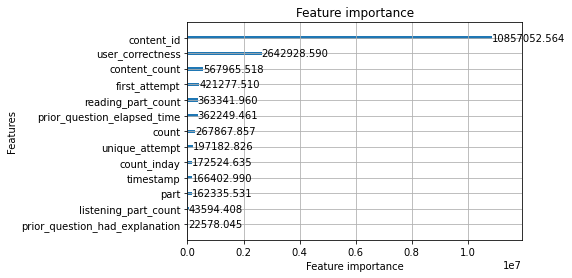

In [22]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])

if FULL_TRAIN:
    model = lgb.train(
        params, 
        tr_data, 
        num_boost_round=4000,
        valid_sets=None, 
        )
else:
    va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

    model = lgb.train(
        params, 
        tr_data, 
        num_boost_round=10000,
        valid_sets=[tr_data, va_data], 
        early_stopping_rounds=50,
        verbose_eval=50
        )

    lgb.plot_importance(model, importance_type='gain')
    plt.show()

# Inference

In [23]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [24]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        parts = prior_part_arrays
        prior_first_attempts = prior_f_attempt_arrays
        
        for user_id, content_id, answered_correctly, part, first_attempt_ornot in zip(user_ids, content_ids, targets, parts, prior_first_attempts):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1
            if part <=4:
                user_listening_dict[user_id] +=1
            else:
                user_reading_dict[user_id] +=1
            user_unique_dict[user_id] += first_attempt_ornot

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    test_df['timestamp'] = (test_df['timestamp'] // 86400000) + 1
    
    prior_part_arrays = test_df['part'].values
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    listening_count = np.zeros(len(test_df), dtype=np.int32)
    reading_count = np.zeros(len(test_df), dtype=np.int32)
    user_count_inday = np.zeros(len(test_df), dtype=np.int32)
    first_attempt_values = []
    user_unique_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id, timestamp) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values, test_df['timestamp'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
        listening_count[i] = user_listening_dict[user_id]
        reading_count[i] = user_reading_dict[user_id]
        first_attempt_values.append(user_content_dict[user_id][content_id])
        user_content_dict[user_id][content_id] = False 
        if user_timestamp_dict[user_id] == timestamp:
            user_count_inday_dict[user_id] += 1
        else:
            user_count_inday_dict[user_id] = 1
            user_timestamp_dict[user_id] = timestamp
        user_count_inday[i] = user_count_inday_dict[user_id]
        user_unique_count[i] = user_unique_dict[user_id]
            
    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
    test_df['count'] = 1
    test_df['count'] = test_df.groupby("user_id")["count"].cumsum()
    test_df['count'] += user_count
    test_df['reading_part_count'] = reading_count
    test_df['listening_part_count'] = listening_count
    test_df["first_attempt"] = first_attempt_values
    test_df['count_inday'] = user_count_inday
    test_df["unique_attempt"] = test_df.groupby("user_id")["first_attempt"].cumsum()
    test_df["unique_attempt"] += user_unique_count

    prior_f_attempt_arrays = test_df['first_attempt'].values
     
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 1.29 s, sys: 90.9 ms, total: 1.38 s
Wall time: 718 ms
